<a href="https://colab.research.google.com/github/faikozcan/MLFraud/blob/main/DNNFraudDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



## Load Data




In [3]:
#https://medium.com/ml-book/train-tf-keras-model-using-feature-coulmn-8de12e65ddec
import numpy as np
import pandas as pd
import requests 
import io
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import feature_column


%matplotlib inline
pd.set_option("display.max_rows", 500, "display.max_columns", 15)
pd.options.display.width=None
pd.options.display.max_columns = None

def get_scal(feature):
  def minmax(x):
    mini = train[feature].min()
    maxi = train[feature].max()
    return (x - mini)/(maxi-mini)
  return(minmax)
url="https://raw.githubusercontent.com/faikozcan/MLFraud/main/dataFiles/Fraud_DataWithCountry.csv"
s=requests.get(url).content
#,usecols=["user_id","signup_time","purchase_time","purchase_value","device_id","source","browser","sex","age","ip_address","ip_country","class"]
dfDownloaded=pd.read_csv(io.StringIO(s.decode('utf-8')),sep = ",",usecols=['signup_time','purchase_time','device_id','user_id','age','sex','source','browser','purchase_value','ip_country','class'])
dfDownloaded.rename(columns={'sex': 'gender'}, inplace=True)
dfDownloaded['purchase_time'] = pd.to_datetime(dfDownloaded['purchase_time'])
dfDownloaded['purchase_hour'] = dfDownloaded['purchase_time'].dt.hour
dfDownloaded['signup_time'] = pd.to_datetime(dfDownloaded['signup_time'])
dfDownloaded['day-of-week'] = dfDownloaded['purchase_time'].dt.day_name().astype(str)
dfDownloaded['day_diff_purchase_signup'] = (dfDownloaded['purchase_time'] - dfDownloaded['signup_time']).dt.days
dfDownloaded['same_Day_Purchase']=np.where(dfDownloaded['day_diff_purchase_signup']==0,1,0)
#assign that dict to a column
device_dict = dict(dfDownloaded.device_id.value_counts())
dfDownloaded['device_TranCount'] = [device_dict[d] for d in dfDownloaded.device_id]
#dfDownloaded['first_tran_with_device'] = np.where(dfDownloaded['device_TranCount']==0,1,0) anlamsız oluyor.
dfDownloaded.drop('purchase_time',axis=1,inplace=True)
dfDownloaded.drop('signup_time',axis=1,inplace=True)
dfDownloaded.drop('day_diff_purchase_signup',axis=1,inplace=True)
dfDownloaded.head(4)

,user_id,purchase_value,device_id,source,browser,gender,age,class,ip_country,purchase_hour,day-of-week,same_Day_Purchase,device_TranCount
0,22058,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,0,Japan,2,Saturday,0,1
1,333320,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,0,United States,1,Monday,1,1
2,1359,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,1,United States,18,Thursday,1,12
3,150084,44,ATGTXKYKUDUQN,SEO,Safari,M,41,0,Unknown,13,Monday,0,1


In [ ]:
#dfDownloaded.astype(object).describe()
dfDownloaded.groupby('device_TranCount')['class'].value_counts()


##Data Augmentation and Train and Test Data Split


In [4]:
from sklearn.utils import shuffle
df=dfDownloaded

train=df.sample(frac=0.75,random_state=200) #random state is a seed value
remaining=df.drop(train.index)
test=remaining.sample(frac=0.5,random_state=200) #random state is a seed value
val=remaining.drop(test.index)
print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')



def oversample(data):
  # Class count
  count_class_0, count_class_1 = data['class'].value_counts()# Class count

  # Random Over Sampling 
  df_class_0 = data[data['class'] == 0]
  df_class_1 = data[data['class'] == 1]
  df_class_1_over = df_class_1.sample(count_class_0,replace=True)
  data = pd.concat([df_class_0,df_class_1_over], axis=0)
  print('Random over-sampling:')
  targetCountsOverSampled=data['class'].value_counts()
  print(targetCountsOverSampled)
  return data




def plotOverSampling(data,row,column,mtitle):
  neg, pos = np.bincount(data['class'])
  total = neg + pos
  print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
      total, pos, 100 * pos / total))
  target_count = data['class'].value_counts()
  print('Class 0:', target_count[0])
  print('Class 1:', target_count[1])
  print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')
  plt.subplot(row,column, 1) # (rows, columns, panel number)
  target_count.plot(kind='bar', title=mtitle)

train=oversample(train)
val=oversample(val)
# test=oversample(test)

# plt.figure()  # create a plot figure
# plotOverSampling(train,1,1,'Training Count(target)')
# # plt.figure()  # create a plot figure
# plotOverSampling(test,2,1,'Test Count(target)')
# plt.figure()  # create a plot figure
# plotOverSampling(val,3,1,'Validation Count(target)')

train = shuffle(train)
test = shuffle(test)
val = shuffle(val)


print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

train.head(20)


113334 train examples
18889 validation examples
18889 test examples
Random over-sampling:
1    102830
0    102830
Name: class, dtype: int64
Random over-sampling:
1    17072
0    17072
Name: class, dtype: int64
205660 train examples
34144 validation examples
18889 test examples


,user_id,purchase_value,device_id,source,browser,gender,age,class,ip_country,purchase_hour,day-of-week,same_Day_Purchase,device_TranCount
130411,366755,32,ABXXKZZZFBJEQ,Ads,Opera,F,28,0,China,19,Wednesday,0,2
131859,204484,15,BWSMVSLCJXMCM,Direct,IE,F,39,1,Japan,16,Wednesday,1,19
17510,275164,44,PDKWIOXZWLPZZ,SEO,IE,F,41,0,Denmark,17,Friday,0,1
111985,327858,30,HZMVEINVXRDTD,Direct,Chrome,F,28,1,United States,5,Saturday,0,1
60995,328053,29,MROXBRWUHOFQD,Ads,IE,M,40,0,United States,17,Friday,0,1
83195,320789,10,GGIAEORYQTDRV,SEO,IE,F,22,0,United States,21,Saturday,0,1
134490,131420,19,TXRBFLGSEOHSM,Ads,Chrome,M,22,1,Unknown,10,Thursday,1,12
122969,332094,26,ELIKEFGFNJRCD,SEO,Chrome,F,28,0,Canada,17,Friday,0,1
109542,279220,44,QRDCVZTJHNRKM,Direct,Chrome,M,47,1,China,9,Friday,1,15
148935,214358,79,BSZATAQWJDTQO,SEO,IE,M,41,0,Finland,7,Saturday,0,1


##Create Colums

In [5]:


#numerical features
num_c = ['purchase_value']
#bucketized numerical features
bucket_c =['age'] 
#categorical features
cat_i_c =['gender','source','browser','day-of-week','purchase_hour'] #indicator columns
cat_e_c =[['ip_country',4]] # embedding column['ip_country',4]

def DoFeatureEngineering(cat_i_c,num_c):
  return np.concatenate((cat_i_c,['same_Day_Purchase'])), np.concatenate((num_c,['device_TranCount']))
  #return cat_i_c, np.concatenate((num_c,['device_TranCount']))

featureEngineeringActive=1
if featureEngineeringActive==1:
  cat_i_c,num_c = DoFeatureEngineering(cat_i_c,num_c)



feature_columns = []

for header in num_c:
  scal_input_fn = get_scal(header)
  feature_columns.append(feature_column.numeric_column(header, normalizer_fn=scal_input_fn))

age = feature_column.numeric_column('age')
age_buckets = feature_column.bucketized_column(age, boundaries=[20,30, 40,50, 60, 100])
feature_columns.append(age_buckets)

#embedding columns
for feature_name in cat_e_c:
  vocabulary = df[feature_name[0]].unique()
  cat_c = tf.feature_column.categorical_column_with_vocabulary_list(feature_name[0], vocabulary)
  embeding = feature_column.embedding_column(cat_c, dimension=feature_name[1])
  feature_columns.append(embeding)

#indicator columns
for feature_name in cat_i_c:
  vocabulary = df[feature_name].unique()
  cat_c = tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary)
  one_hot = feature_column.indicator_column(cat_c)
  feature_columns.append(one_hot)


print('Total number of feature coumns: ',len(feature_columns))


Total number of feature coumns:  10


##Run Model

In [6]:
from keras.metrics import Precision, Recall
from tensorflow.keras import layers
from tensorflow.keras import regularizers
import ipaddress as ipLib
import math
from keras import backend as K
import os
# A utility method to create a tf.data dataset from a Pandas Dataframe


def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  dataframe = dataframe.copy()
  labels = dataframe.pop('class')
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  return ds


batch_size = 32
train_ds = df_to_dataset(train,shuffle=True, batch_size=batch_size)
print(train_ds)
val_ds = df_to_dataset(val, shuffle=True, batch_size=batch_size)

feature_layer = tf.keras.layers.DenseFeatures(feature_columns)
# To apply L1 and L2 regularization, you can set dnn_optimizer to:
custom_Optimizer=  tf.keras.optimizers.Adam(
    learning_rate=0.01)


def get_Best_Model():
  model=tf.keras.Sequential(
      [
       feature_layer,
       layers.Dense(8,activation='relu'),
       layers.Dropout(0.1),
       layers.Dense(8,activation='relu'),
       layers.Dropout(0.1),
       layers.Dense(1,activation='sigmoid')
      ])
  model.compile(optimizer=custom_Optimizer, loss='binary_crossentropy',  metrics=['binary_accuracy', Precision(), Recall()]);

  return model;

model=get_Best_Model();
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=False,
                                                 verbose=1)

callbacks = [
    tf.keras.callbacks.TensorBoard(
        log_dir='logs'
    ),
    tf.keras.callbacks.EarlyStopping(monitor='binary_accuracy', patience=3)
]
history = model.fit(train_ds,
          validation_data=val_ds,
          epochs=10,
          verbose=1,
         callbacks=callbacks)
model.summary()

<BatchDataset shapes: ({user_id: (None,), purchase_value: (None,), device_id: (None,), source: (None,), browser: (None,), gender: (None,), age: (None,), ip_country: (None,), purchase_hour: (None,), day-of-week: (None,), same_Day_Purchase: (None,), device_TranCount: (None,)}, (None,)), types: ({user_id: tf.int64, purchase_value: tf.int64, device_id: tf.string, source: tf.string, browser: tf.string, gender: tf.string, age: tf.int64, ip_country: tf.string, purchase_hour: tf.int64, day-of-week: tf.string, same_Day_Purchase: tf.int64, device_TranCount: tf.int64}, tf.int64)>
Epoch 1/10
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
6425/6427 [============================>.] - ETA: 0s - loss: 0.4645 - binary_accuracy: 0.7639 - precision: 0.9567 - recall: 0.5556WARNING:tensorflow:Layers in a Sequential model should only have a single input tensor, but we receive a <class 'dict'> input: {'user_id': <tf.Tensor 'ExpandDims_11:0' shape

In [7]:

# test1=test
# test1 = test[test['class']==1]
# test_ds1 = df_to_dataset(test1, shuffle=True, batch_size=batch_size)
# print('positive test result')
# loss, accuracy,precision, recall = model.evaluate(test_ds1,steps=500)
model.save('DNNFraudDetection.h5')


test_ds2 = df_to_dataset(test, shuffle=True, batch_size=batch_size)
print('all test result')
loss, accuracy ,precision, recall= model.evaluate(test_ds2,steps=5000)

batched_filtered = test_ds2.unbatch().filter(lambda x,y: y==1).batch(1)
prediction_Array=batched_filtered.take(10)
result=model.predict(prediction_Array)

for next_element in prediction_Array:
  tf.print(next_element)



result[result < 0.5] = 0.
result[result > 0.5] = 1.
print(result)

  



all test result
5000/5000 [==============================] - 1s 251us/step - loss: 0.3436 - binary_accuracy: 0.9140 - precision: 0.5427 - recall: 0.7153
Consider rewriting this model with the Functional API.
({'age': [41],
  'browser': ["Chrome"],
  'day-of-week': ["Friday"],
  'device_TranCount': [1],
  'device_id': ["MHBYKCTDPTHBR"],
  'gender': ["M"],
  'ip_country': ["United Kingdom"],
  'purchase_hour': [9],
  'purchase_value': [32],
  'same_Day_Purchase': [0],
  'source': ["Ads"],
  'user_id': [265534]},
 [1])
({'age': [24],
  'browser': ["Chrome"],
  'day-of-week': ["Monday"],
  'device_TranCount': [1],
  'device_id': ["FTUITODLZIURI"],
  'gender': ["F"],
  'ip_country': ["India"],
  'purchase_hour': [14],
  'purchase_value': [54],
  'same_Day_Purchase': [0],
  'source': ["SEO"],
  'user_id': [321072]},
 [1])
({'age': [49],
  'browser': ["IE"],
  'day-of-week': ["Friday"],
  'device_TranCount': [2],
  'device_id': ["BBHBEPKKHEMSE"],
  'gender': ["F"],
  'ip_country': ["Germany"]

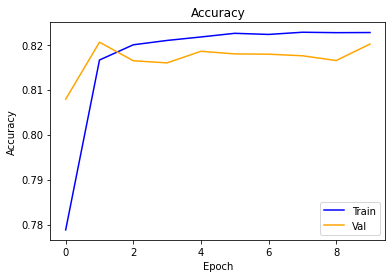

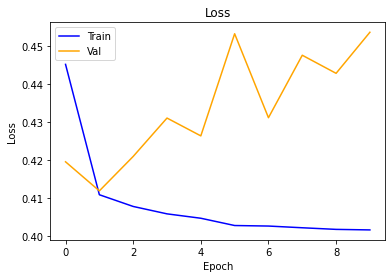

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

epochs = range(10)

plt.title('Accuracy')
plt.plot(epochs,  history.history['binary_accuracy'], color='blue', label='Train')
plt.plot(epochs, history.history['val_binary_accuracy'], color='orange', label='Val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

_ = plt.figure()
plt.title('Loss')
plt.plot(epochs, history.history['loss'], color='blue', label='Train')
plt.plot(epochs, history.history['val_loss'], color='orange', label='Val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [ ]:
import torch
model_save_name = 'classifier.pt'
path = F"/content/gdrive/My Drive/{model_save_name}" 
torch.save(model.state_dict(), path)

In [ ]:
# Set up a logs directory, so Tensorboard knows where to look for files
import os
import os
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorboard.plugins import projector
%reload_ext tensorboard
%load_ext tensorboard
log_dir='/logs'




weights = tf.Variable(model.layers[0].get_weights()[0][1:])

checkpoint = tf.train.Checkpoint(embedding=weights)
checkpoint.save(os.path.join(log_dir, "embedding.ckpt"))

# Set up config
config = projector.ProjectorConfig()
embedding = config.embeddings.add()
# The name of the tensor will be suffixed by `/.ATTRIBUTES/VARIABLE_VALUE`
embedding.tensor_name = "embedding/.ATTRIBUTES/VARIABLE_VALUE"
embedding.metadata_path = 'metadata.tsv'
projector.visualize_embeddings(log_dir, config)



%tensorboard --logdir log_dir
